jump down
- [Read in the data](#data)
- [Looking at Orders](#order)
- [Merging all dataframes together](#merging)
- [Grouping](#grouping)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

%matplotlib inline

Just some initial EDA

<a id='data'></a>
# Read in the data

In [2]:
order_products_train= pd.read_csv("./data/order_products__train.csv")
order_products_prior = pd.read_csv("./data/order_products__prior.csv")
orders = pd.read_csv("./data/orders.csv")
products = pd.read_csv("./data/products.csv")
aisles = pd.read_csv("./data/aisles.csv")
departments = pd.read_csv("./data/departments.csv")

In [3]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1.0
1,2,28985,2,1.0
2,2,9327,3,0.0
3,2,45918,4,1.0
4,2,30035,5,0.0


In [5]:
order_products_train.shape

(1384617, 4)

In [6]:
orders.eval_set.value_counts()

prior    2487355
train     101243
test       58108
Name: eval_set, dtype: int64

In [7]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


# Products

In [13]:
order_products_freq = pd.merge(order_products_prior, products, on='product_id', how='left')

prod_freq = order_products_freq['product_name'].value_counts().reset_index().head(20)
prod_freq.columns = ['product_name', 'frequency_count']
prod_freq.head()

,product_name,frequency_count
0,Banana,67848
1,Bag of Organic Bananas,54332
2,Organic Strawberries,38025
3,Organic Baby Spinach,34614
4,Organic Hass Avocado,30459


In [22]:
prod_freq[prod_freq['product_name'] == "Chocolate Sandwich Cookies"]

,product_name,frequency_count


In [17]:
products['product_freq']= products['product_name'].map(prod_freq.frequency_count)
products.head()

,product_id,product_name,aisle_id,department_id,product_freq
0,1,Chocolate Sandwich Cookies,61,19,NaN
1,2,All-Seasons Salt,104,13,NaN
2,3,Robust Golden Unsweetened Oolong Tea,94,7,NaN
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,NaN
4,5,Green Chile Anytime Sauce,5,13,NaN


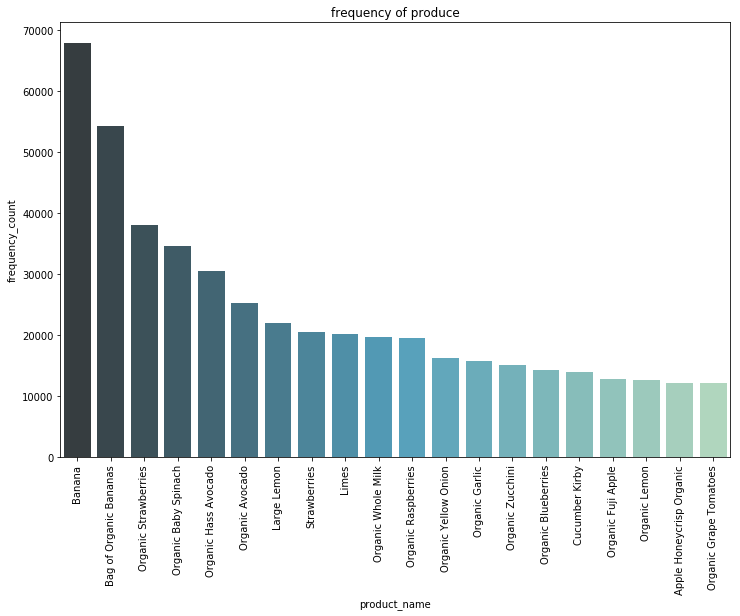

In [18]:
#so many organics!!! 
plt.figure(figsize = (12,8))
sns.barplot(x = prod_freq.product_name, y = prod_freq.frequency_count, palette="GnBu_d")
plt.title('frequency of produce')
plt.xticks(rotation = 90);

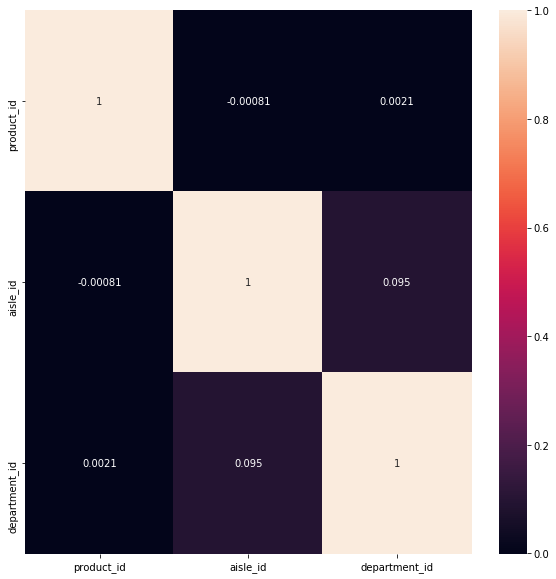

In [54]:
plt.figure(figsize = (10,10))
sns.heatmap(products.corr(), annot = True);

# Orders

In [19]:
orders['days_since_prior_order'].fillna(value = 0, axis =0, inplace = True)

orders[['days_since_prior_order', 'order_number']].head()

,days_since_prior_order,order_number
0,0.0,1
1,15.0,2
2,21.0,3
3,29.0,4
4,28.0,5


# Order frequency by time of day

Most people order their groceries between the hours of 9 amd 4pm

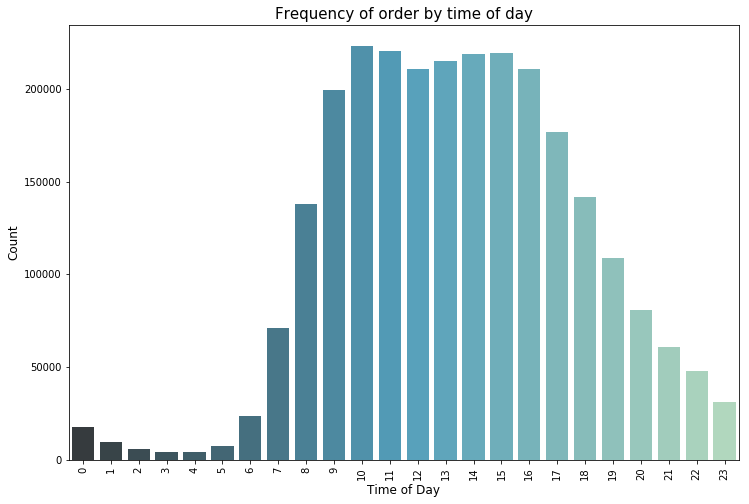

In [20]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, palette="GnBu_d")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by time of day", fontsize=15)
plt.show()

# Order frequency by day

Most people get their groceries on Monday and Tuesday

In [26]:
order_products_train_merged = pd.merge(order_products_train, orders, on = "order_id")

In [28]:
day_by_reorder = order_products_train_merged.groupby(['order_dow'])['reordered'].aggregate('mean').reset_index()
day_by_reorder

,order_dow,reordered
0,0,0.609901
1,1,0.598928
2,2,0.589922
3,3,0.588088
4,4,0.596444
5,5,0.608267
6,6,0.592719


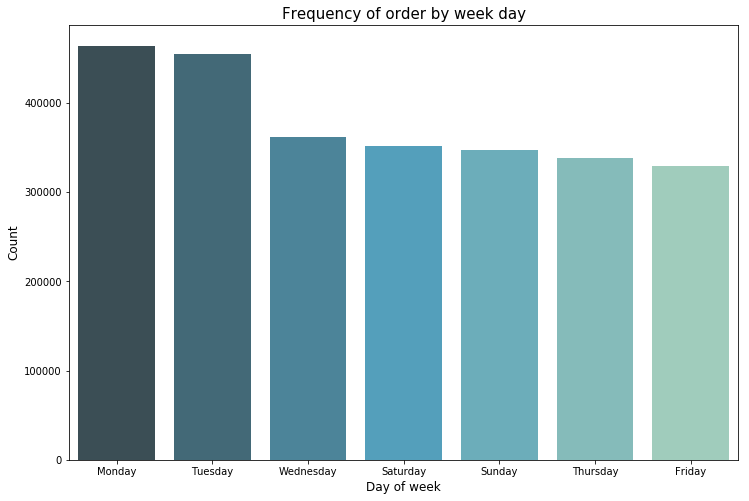

In [29]:
import calendar
days=[]

for i in orders['order_dow']:
    days.append(calendar.day_name[i])

orders['converted_dow']=days

#Finding out the busiest day of the week
plt.figure(figsize=(12,8))
sns.countplot(x="converted_dow", data=orders, order=orders['converted_dow'].value_counts().index, palette="GnBu_d")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Frequency of order by week day", fontsize=15)
plt.show()
count_dow = orders.groupby('order_dow')['order_id']
count_dow

#  Frequency of reorders

In [32]:
orders_since_last = orders.groupby(['days_since_prior_order'])['order_id'].agg('count')

In [33]:
colors = ['skyblue'] * len(orders_since_last.index)
peaks  = [0,7,30] 
for i in peaks:
    colors[i] = 'forestgreen'

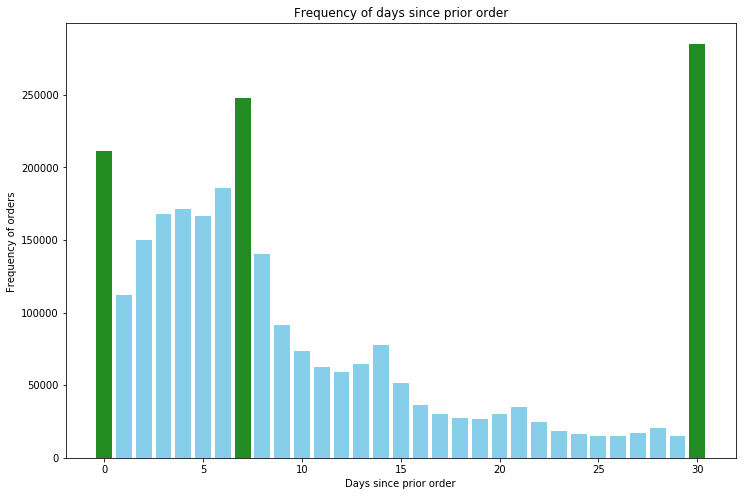

In [65]:
plt.figure(figsize = (12,8))
plt.bar(orders_since_last.index, orders_since_last, color = colors)
plt.title('Frequency of days since prior order')
plt.xlabel('Days since prior order')
plt.ylabel('Frequency of orders ');

In [35]:
#% reordered in prior
print(order_products_prior.reordered.sum() / order_products_prior.shape[0])


#% reordered in train 
print(order_products_train.reordered.sum() / order_products_prior.shape[0])

0.589640443404912
0.1781616051792624


So, about 59% of products are re-ordered, according to the training data. 

# Grouped between hour of day and day of the week 

In [58]:
order_freq = orders.groupby(["order_dow", 
                                 "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
order_freq.head()

order_freq = order_freq.pivot('order_dow', 'order_hour_of_day', 'order_number')
order_freq

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,3069,1790,1069,720,621,907,2562,9572,21602,31412,...,42106,41794,38178,30753,22894,17603,14230,11170,8756,5298
1,2877,1411,860,574,614,1219,4122,12879,26440,40059,...,36259,35954,34774,28516,22357,17127,12523,9300,6992,4363
2,2353,1200,734,554,580,1085,3650,10178,19088,28108,...,28791,29110,29077,24844,20428,15551,11648,8331,6302,4145
3,2257,1160,746,495,562,1060,3528,9547,17490,25112,...,26813,27856,27325,23571,19430,14898,10668,7953,6466,3981
4,2021,1162,702,535,557,1037,3460,9673,16952,24392,...,25968,26398,26242,22645,18905,14937,10961,8354,6846,4443
5,2473,1302,765,660,686,1244,3746,10381,18566,26519,...,28930,29021,27697,23221,18916,14604,10333,7422,5826,4105
6,2534,1461,963,648,593,867,2476,8728,17804,23792,...,29984,29378,27531,23431,18610,14197,10386,8142,6588,4718


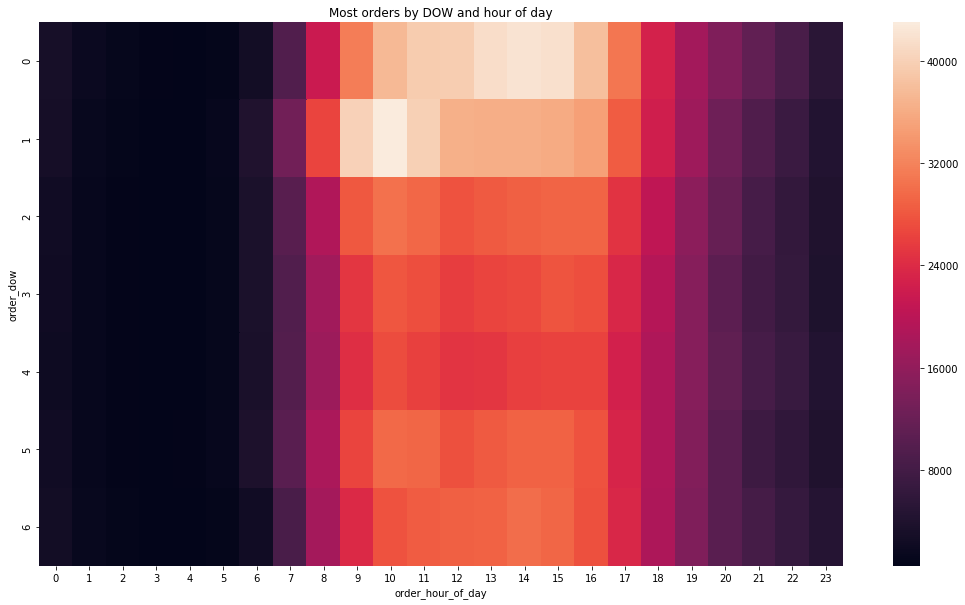

In [59]:
plt.figure(figsize = (18,10))
sns.heatmap(order_freq)
plt.title('Most orders by DOW and hour of day');

From this we can tell that most people order groceries between 10 and 12 on Monday's, and 1 and 3 on Sunday's